__GeekBrains, факультет Искусственного интелекта__<br>
__курс "Алгоритмы анализа данных" (06 окт 2022 - 08 ноя 2022)__<br>
__Урок 4. Деревья решений__

### Домашнее задание студента Бакеева А.П.
Сдайте задание до: 25 окт., 20:00 MSK

__Этот файл для удобства проверки разбит на две части:__<br>
* [I часть](#first) <br>
повторение кода, который был предоставлен на уроке (из методички). Единственное изменение в этой части по сравнению с лекцией -
 * [новая генерация данных](#first_1)<br><br>
* [II часть](#second) <br>
выполнение домашнего задания (в этой части полностью переписаны те функции, которые требовали изменения для выполнения ДЗ)
 * [1.1. минимальное количество объектов в листе - `min_leaf`](#second_1)<br>
 * [1.2. максимальная глубина дерева - `max_dipth`](#second_2)<br>
 * [3. дерево для задачи регрессии](#second_3)

### <center>I часть<a class="anchor" id="first"></a><center>

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import random

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

### <center>новая генерация данных<a class="anchor" id="first_1"></a><center>

__Сгенерируем более запутанные данные, для того, чтобы разница в способах останова алгоритма была более явной__ <br>
Для этого в фуркции `datasets.make_classification` увеличим значения параметра `flip_y` <br>
При увеличении его значения возрастает шум  в метках и усложняется задача классификации (Larger values introduce noise in the labels and make the classification task harder) 

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( n_samples=100,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      flip_y=0.4, # default value = 0.01 
                                                      random_state=5)

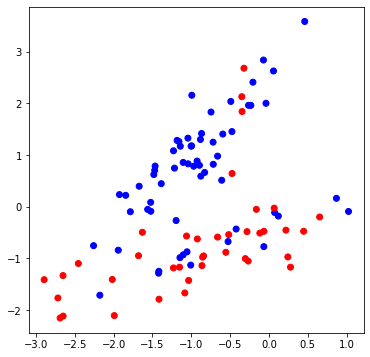

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Неопределенность Джини:
$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

Функционал качества:  

$$Q = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$$

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):
    #print (f'\t\t\t quality, current_gini = {current_gini}')

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    #print (f'\t\t split, t = {t}')
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):    
    #print (f'\t find_best_split, labels = {labels}')
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    #print(n_features)
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        #t_values = np.unique([row[index] for row in data])
        t_values = np.unique(data[:, index])
        #print(t_values)
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):    
    #print (f'build_tree, labels = {labels}')

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [15]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + 'ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "--> ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "--> ")
    
print_tree(my_tree)

УЗЕЛ: индекс = 1, порог = -0.03
--> Левая ветка:
--> УЗЕЛ: индекс = 0, порог = -1.1
--> --> Левая ветка:
--> --> УЗЕЛ: индекс = 1, порог = -1.17
--> --> --> Левая ветка:
--> --> --> УЗЕЛ: индекс = 0, порог = -2.02
--> --> --> --> Левая ветка:
--> --> --> --> ЛИСТ: прогноз = 0, объектов = 5
--> --> --> --> Правая ветка:
--> --> --> --> ЛИСТ: прогноз = 0, объектов = 5
--> --> --> Правая ветка:
--> --> --> ЛИСТ: прогноз = 1, объектов = 8
--> --> Правая ветка:
--> --> УЗЕЛ: индекс = 0, порог = -0.12
--> --> --> Левая ветка:
--> --> --> ЛИСТ: прогноз = 0, объектов = 14
--> --> --> Правая ветка:
--> --> --> ЛИСТ: прогноз = 0, объектов = 7
--> Правая ветка:
--> УЗЕЛ: индекс = 0, порог = -0.49
--> --> Левая ветка:
--> --> ЛИСТ: прогноз = 1, объектов = 23
--> --> Правая ветка:
--> --> ЛИСТ: прогноз = 0, объектов = 8


In [17]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [18]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

$$accuracy=\frac{1}{l}\sum^l_{i=1}[pred_i=y_i]$$

In [19]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

87.14285714285714

In [21]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

53.333333333333336

C:\Users\s2e\AppData\Local\Temp/ipykernel_9792/3498025306.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
C:\Users\s2e\AppData\Local\Temp/ipykernel_9792/3498025306.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=53.33')

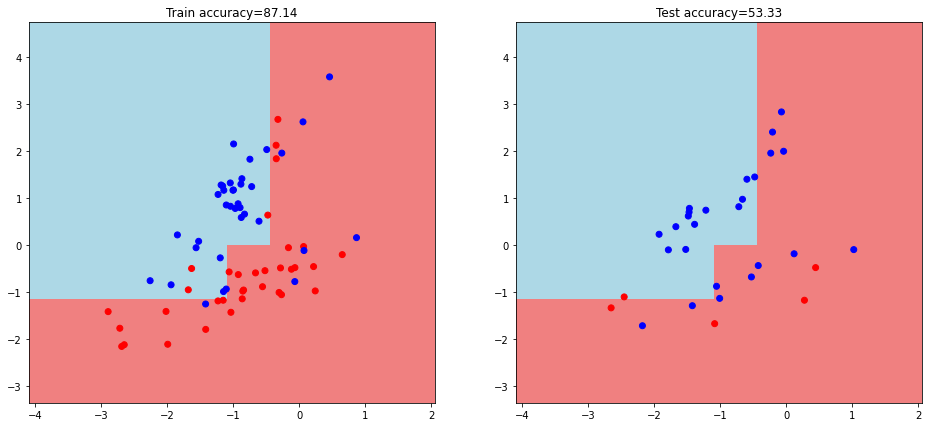

In [22]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

## Домашние задания

1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность с помощью визуализации дерева (функция `print_tree`). 
2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.
2. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

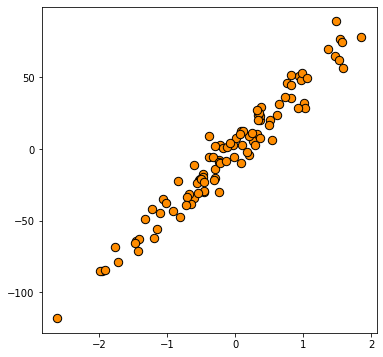

In [23]:
# 3 задание
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

### <center>II часть<a class="anchor" id="second"></a><center>

__1.__ В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе - `min_leaf`, максимальная глубина дерева - `max_dipth`, максимальное количество листьев `max_num_leaf` и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность с помощью визуализации дерева (функция `print_tree`). 

__Решение 1.1__

### <center>минимальное количество объектов в листе - `min_leaf`<a class="anchor" id="second_1"></a><center>

для остановки работы алгоритма по ограничению через минимальное количество объектов в листе - `min_leaf`<br>
доработаем две функции `find_best_split` и `build_tree` 

Добавим в них дополнительный параметр `min_leaf` - минимальное количество объектов в листе

In [24]:
# Нахождение наилучшего разбиения

def find_best_split_2_0(data, labels, min_leaf_num=5):    
    #print (f'\t find_best_split_2_0, min_leaf_num = {min_leaf_num}, labels = {labels}')
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = min_leaf_num

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    #print(n_features)
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        # t_values = np.unique(data[:, index])
        #print(t_values)
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [25]:
def build_tree_2_0(data, labels, min_leaf=20):
    #print (f'build_tree_2_0, labels = {labels}')
    
    min_leaf_num = min_leaf
    
    quality, t, index = find_best_split_2_0(data, labels, min_leaf_num)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_2_0(true_data, true_labels, min_leaf_num)
    false_branch = build_tree_2_0(false_data, false_labels, min_leaf_num)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Построим дерево по обучающей для минмально возможного значения парамета min_leaf = 1

In [26]:
# Построим дерево по обучающей для min_leaf = 1
my_tree = build_tree_2_0(train_data, train_labels, 1)

In [27]:
print_tree(my_tree)

УЗЕЛ: индекс = 1, порог = -0.03
--> Левая ветка:
--> УЗЕЛ: индекс = 0, порог = -1.1
--> --> Левая ветка:
--> --> УЗЕЛ: индекс = 1, порог = -1.17
--> --> --> Левая ветка:
--> --> --> УЗЕЛ: индекс = 1, порог = -1.41
--> --> --> --> Левая ветка:
--> --> --> --> ЛИСТ: прогноз = 0, объектов = 7
--> --> --> --> Правая ветка:
--> --> --> --> УЗЕЛ: индекс = 0, порог = -1.42
--> --> --> --> --> Левая ветка:
--> --> --> --> --> ЛИСТ: прогноз = 1, объектов = 1
--> --> --> --> --> Правая ветка:
--> --> --> --> --> ЛИСТ: прогноз = 0, объектов = 2
--> --> --> Правая ветка:
--> --> --> УЗЕЛ: индекс = 0, порог = -1.63
--> --> --> --> Левая ветка:
--> --> --> --> УЗЕЛ: индекс = 0, порог = -1.94
--> --> --> --> --> Левая ветка:
--> --> --> --> --> ЛИСТ: прогноз = 1, объектов = 2
--> --> --> --> --> Правая ветка:
--> --> --> --> --> ЛИСТ: прогноз = 0, объектов = 2
--> --> --> --> Правая ветка:
--> --> --> --> ЛИСТ: прогноз = 1, объектов = 4
--> --> Правая ветка:
--> --> УЗЕЛ: индекс = 0, порог = -0.12
--

Визуализируем результаты на графике

C:\Users\s2e\AppData\Local\Temp/ipykernel_9792/3351372691.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
C:\Users\s2e\AppData\Local\Temp/ipykernel_9792/3351372691.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=70.00')

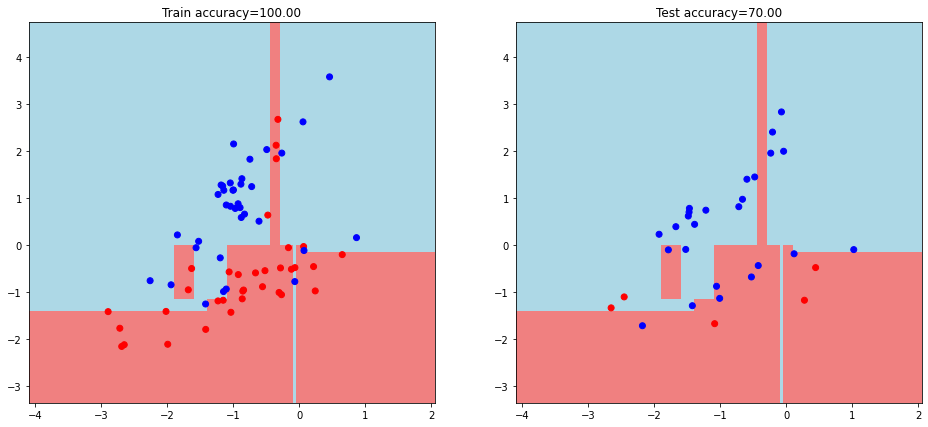

In [28]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Очивидно что модель переобучилась, но мы же и виноваты - поставили ей задачу строить дерево, так, чтобы в самом крайнем случае в листах могло быть по одному объекту

__Решение 1.2__

### <center>максимальная глубина дерева - `max_dipth`<a class="anchor" id="second_2"></a><center>

в качестве значения глубины дерева я взял количество обращений к функции `split`, которое фиксируется в переменной `dipth`<br>
критерий останова - когда значение `dipth` начинает превышать `dipth_limit`, которое задается в параметрах функции `build_tree_2_1`<br>
контроль этого условия реализован в функции `find_best_split_2_1`

In [29]:
# Нахождение наилучшего разбиения

def find_best_split_2_1(data, labels, min_leaf_num, dipth_limit):    
    #print (f'\t find_best_split_2_1, min_leaf_num = {min_leaf_num}, labels = {labels}')
    
    #  контроль глубины
    global dipth
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = min_leaf_num

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    #print(n_features)
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        # t_values = np.unique(data[:, index])
        #print(t_values)
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
                
            #  пропускаем разбиения, глубина которых более dipth_limit
            if dipth > dipth_limit :                    
                #print(f'\t\t dipth={dipth}')
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [30]:
def build_tree_2_1(data, labels, min_leaf_num=5, dipth_limit=2):
    #print (f'build_tree_2_1, labels = {labels}')
    
    #  контроль глубины
    global dipth
    
    #min_leaf_num = 1
    
    quality, t, index = find_best_split_2_1(data, labels, min_leaf_num, dipth_limit)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)     
    
    dipth += 1
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева    
    true_branch = build_tree_2_1(true_data, true_labels, min_leaf_num, dipth_limit)    
    false_branch = build_tree_2_1(false_data, false_labels, min_leaf_num, dipth_limit)
        
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Построим дерево по обучающей для минмально возможного значения парамета depth_limit = 4

In [31]:
# Построим дерево 
dipth = 0
my_tree_2_1 = build_tree_2_1(train_data, train_labels, min_leaf_num=1, dipth_limit=4)
print_tree(my_tree_2_1)

УЗЕЛ: индекс = 1, порог = -0.03
--> Левая ветка:
--> УЗЕЛ: индекс = 0, порог = -1.1
--> --> Левая ветка:
--> --> УЗЕЛ: индекс = 1, порог = -1.17
--> --> --> Левая ветка:
--> --> --> УЗЕЛ: индекс = 1, порог = -1.41
--> --> --> --> Левая ветка:
--> --> --> --> ЛИСТ: прогноз = 0, объектов = 7
--> --> --> --> Правая ветка:
--> --> --> --> УЗЕЛ: индекс = 0, порог = -1.42
--> --> --> --> --> Левая ветка:
--> --> --> --> --> ЛИСТ: прогноз = 1, объектов = 1
--> --> --> --> --> Правая ветка:
--> --> --> --> --> ЛИСТ: прогноз = 0, объектов = 2
--> --> --> Правая ветка:
--> --> --> ЛИСТ: прогноз = 1, объектов = 8
--> --> Правая ветка:
--> --> ЛИСТ: прогноз = 0, объектов = 21
--> Правая ветка:
--> ЛИСТ: прогноз = 1, объектов = 31


C:\Users\s2e\AppData\Local\Temp/ipykernel_9792/2508736178.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
C:\Users\s2e\AppData\Local\Temp/ipykernel_9792/2508736178.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=70.00')

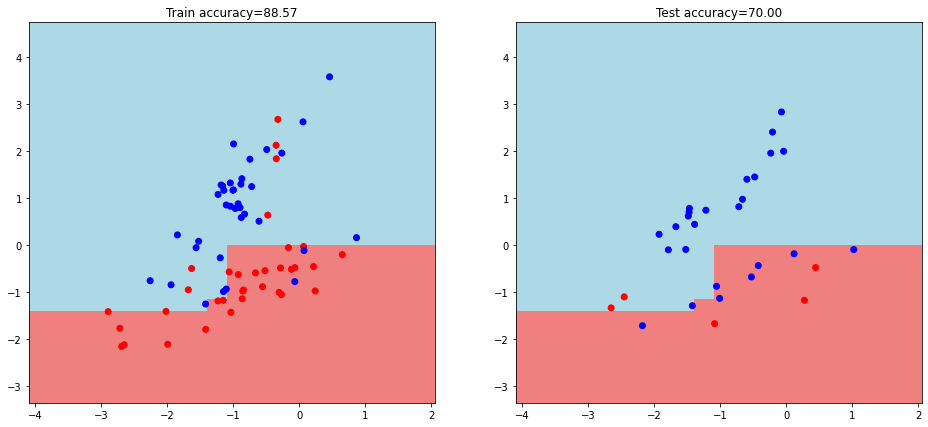

In [32]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree_2_1)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree_2_1)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_2_1)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

__Решение 3__

### <center>дерево для задачи регрессии<a class="anchor" id="second_3"></a><center>

В случае **регрессии** разброс будет характеризоваться дисперсией или же *среднеквадратичным отклонением*, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

Реализуем критерий информативности среднеквадратичного отклонения

In [33]:
# Функция для расчета дисперсии массива array

def mse(array):    
    mse = np.mean((array - array.mean())**2)
    return mse

In [34]:
# Расчет качества

def quality_r(left_labels, right_labels, current_mse):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

class Node для регрессии не изменится, а вот class Leaf надо переработать

In [35]:
# Доработаем класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return self.labels.mean()

Переоформим другие необходимые функции

In [36]:
# Нахождение наилучшего разбиения

def find_best_split_r(data, labels):    
    #print (f'\t find_best_split, labels = {labels}')
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_mse = mse(labels)
    #current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    #print(n_features)
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        #t_values = np.unique([row[index] for row in data])
        t_values = np.unique(data[:, index])
        #print(t_values)
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_r(true_labels, false_labels, current_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [37]:
# Построение дерева с помощью рекурсивной функции

def build_tree_r(data, labels):    
    #print (f'build_tree, labels = {labels}')

    quality, t, index = find_best_split_r(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Формируем датасет

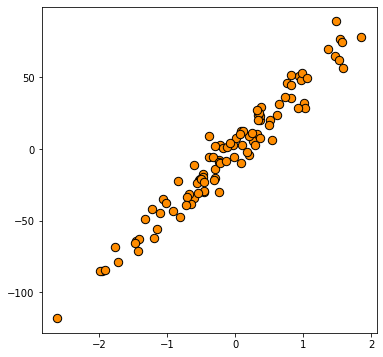

In [38]:
regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

Строим дерево и выводим результаты на график

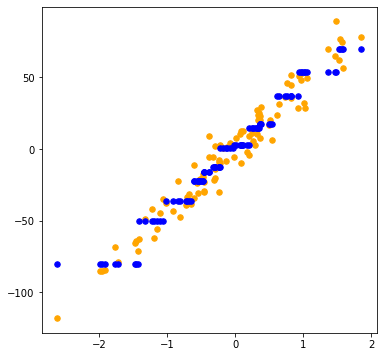

In [39]:
my_tree_r = build_tree_r(regression_data, regression_labels)
answers = predict(regression_data, my_tree_r)

plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='orange', s=30);
plt.scatter(regression_data, answers, c='b', s=30);